
# Examples for DEGANN

This notebook demonstrates basic use cases for the **DEGANN** package.

In [84]:
# Install DEGANN

!pip install degann

In [85]:
import degann
from degann.networks.imodel import IModel

import numpy as np

from random import randint

In [86]:
# Prepare data for neural network training

def f_3x2(x):
    return 3*x**2


data_size = 1000
x_data = np.array([[i / data_size] for i in range(0, data_size + 1)])
y_data = np.array([f_3x2(x) for x in x_data])

train_data_size = 200

train_idx = [randint(0, len(x_data) - 1) for _ in range(train_data_size)]
train_idx.sort()
train_data_x = x_data[train_idx, :]  # X data
train_data_y = y_data[train_idx, :]  # Y data


## Neural network examples



### Creating a neural network


A neural network with input and output layer sizes equal to 1 and hidden layer sizes `[32, 16, 8]`.

In [87]:
nn_1_32_16_8_1 = IModel(
    input_size=1,
    block_size=[32, 16, 8],
    output_size=1
)
print(nn_1_32_16_8_1)

IModel tensorflow_dense_net_17
Layer TFDense0
weights shape = (1, 32)
Layer TFDense1
weights shape = (32, 16)
Layer TFDense2
weights shape = (16, 8)
Layer OutLayerTFDense
weights shape = (8, 1)



A neural network with an input layer size of 1, an output layer size of 3, hidden layer sizes of `[10, 10]` and activation functions `[swish, relu]` for the hidden layers.

In [88]:
shape = [10, 10]
activations = ["swish", "relu"] + ["linear"]  # additional activation function for output layer

nn_1_10_10_3 = IModel(
    input_size=1,
    block_size=shape,
    output_size=1,
    activation_func=activations,
)

print("Activation functions per layer for n_1_10_10_3")
acts = nn_1_10_10_3.get_activations
for i, act_name in enumerate(activations):
    print(i, act_name)

print(nn_1_10_10_3)

Activation functions per layer for n_1_10_10_3
0 swish
1 relu
2 linear
IModel tensorflow_dense_net_18
Layer TFDense0
weights shape = (1, 10)
Layer TFDense1
weights shape = (10, 10)
Layer OutLayerTFDense
weights shape = (10, 1)




### Neural network training


In [89]:
# Prepare network for training

nn_1_32_16_8_1.compile(
    optimizer="Adam",
    loss_func="MaxAbsoluteDeviation",  # max(abs(y_true - y_prediction))
    metrics=[]
)

In [90]:
# Train network (something about 5 sec. on Google Colab)

loss_before_train = nn_1_32_16_8_1.evaluate(x_data, y_data, verbose=0)

nn_1_32_16_8_1.train(train_data_x, train_data_y, epochs=50, verbose=0)

loss_after_train = nn_1_32_16_8_1.evaluate(x_data, y_data, verbose=0)

print(f"Loss before training = {loss_before_train}")
print(f"Loss after training = {loss_after_train}")

Loss before training = 0.9465698003768921
Loss after training = 0.8159846663475037



### Export neural network


Exporting a neural network as a set of parameters

In [91]:
nn_1_32_16_8_1.export_to_file("some_path")

Exporting a neural network as C++ code

In [92]:
nn_1_32_16_8_1.export_to_cpp("some_path")


## Search algorithms examples


In [93]:
from degann.search_algorithms import random_search_endless, simulated_annealing, pattern_search, grid_search


### Pattern search


In this example, the training of neural networks with the following topologies:

 * 0 hidden layers
 * hidden layer with 20 neurons and (parabolic activation function)[https://rairi.frccsc.ru/en/publications/426]
 * hidden layer with 20 neurons and exponential activation function
 * two hidden layers with 10 neurons each and a parabolic activation function for each layer
 * two hidden layers with 10 neurons each and an exponential activation function for each layer

For each neural network, the activation function for the output layer is a linear activation function. The size of the input and output layers is automatically determined from the passed data.

Only MSE was chosen as the loss function used in training, as metrics for assessing the quality of training --- MaxAbsoluteDeviation, MSLE, as an optimizer --- Adam. Training is carried out over 20 epochs, and there is no data normalization.

In [94]:
# Takes about 3 min. in Google Colab

config = {
    "loss_functions": ["MeanSquaredError"],
    "optimizers": ["Adam"],
    "metrics": ["MaxAbsoluteDeviation", "MeanSquaredLogarithmicError"],
    "net_shapes": [
        [],  # neural network without hidden layers
        [10],
        [5, 5]
    ],
    "activations": ["parabolic", "exponential"],
    "validation_split": 0,
    "rates": [1e-2],
    "epochs": [10],
    "normalize": [False],
    "use_rand_net": False,
}

best_nns = pattern_search(
    x_data=train_data_x,
    y_data=train_data_y,
    x_val=x_data,
    y_val=y_data,
    **config
)
print(best_nns)

[[{'loss_function': 'MeanSquaredError', 'normalize': False, 'optimizer': 'Adam', 'epochs': 10, 'eps': 0.01, 'metrics': ['MaxAbsoluteDeviation', 'MeanSquaredLogarithmicError'], 'validation_metrics': ['Huber', 'LogCosh', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MaxAbsolutePercentageError', 'MeanSquaredError', 'RootMeanSquaredError', 'MeanSquaredLogarithmicError', 'RelativeAbsoluteError', 'MaxAbsoluteDeviation'], 'nets_param': [[[], ['linear'], [None]], [[10], ['parabolic', 'linear'], [None, None]], [[10], ['exponential', 'linear'], [None, None]], [[5, 5], ['parabolic', 'parabolic', 'linear'], [None, None, None]], [[5, 5], ['exponential', 'exponential', 'linear'], [None, None, None]]], 'validation_split': 0, 'use_rand_net': False}, 0.17097823321819305, 0.1110386773943901, <degann.networks.imodel.IModel object at 0x7887e3aee470>]]



### Neural network coding


The DEGANN package uses a representation of the topology of neural networks in the form of a word from the topology language.

The alphabet for the language consists of symbols that describe possible hidden layers in the neural network. For each symbol, the first `k` hexadecimal letters describe the number of neurons in the layer, and the last symbol describes the activation function for that layer.
The package defaults to symbols where the layer size is encoded with a single hexadecimal letter and a offset of `8`, so hidden layer sizes range from 8 to 23 inclusive.

For example, a neural network with topologies `[8 neurons and activation function softplus, 23 neurons and activation function swish, 12 neurons and activation function gelu]` will look like “0af842” as a result of encoding.

You can change the number of hexadecimal letters allocated to encode the size of hidden layers using the `block_size` parameter, and the offset can be changed using `offset` (layer size = hex_to_dec + offset)

In [95]:
# Examples of coding

from degann.search_algorithms.nn_code import encode, decode, act_to_hex, hex_to_act, alph_n_full

shape_1 = [10, 8, 23, 16]
activations_1 = ["tanh", "exponential", "relu", "swish", "linear"]
nn_for_code_1 = IModel(
    input_size=1,
    block_size=shape_1,
    output_size=1,
    activation_func=activations_1
)
code_1 = encode(nn_for_code_1, offset=8)
print(f"Neural network with shape {shape_1} and activations {activations_1} encoded in {code_1}")

shape_1_from_code, activations_1_from_code = decode(code_1, block_size=1, offset=8)
print(f"{code_1} decoded in shape {shape_1_from_code} and activations {activations_1_from_code}")

code_2 = "e4aa00"
shape_2_from_code, activations_2_from_code = decode(code_2, block_size=2, offset=1)
print(f"{code_2} with block_size=2 and offset=1 decoded in shape {shape_2_from_code} and activations {activations_2_from_code}")

Neural network with shape [10, 8, 23, 16] and activations ['tanh', 'exponential', 'relu', 'swish', 'linear'] encoded in 2904f188
2904f188 decoded in shape [10, 8, 23, 16] and activations ['tanh', 'exponential', 'relu', 'swish']
e4aa00 with block_size=2 and offset=1 decoded in shape [229, 161] and activations ['softplus', 'elu']



### Grid search


In this example, the training of neural networks with the following topologies:

 - [0a] --- one hidden layer with 8 neurons and softplus activation function
 - [42] --- one hidden layer with 12 neurons and gelu activation function
 - [0a, 0a] --- two hidden layers with 8 neurons each and softplus activation functions
 - [0a, 42] --- two hidden layers with 8 and 12 neurons and activation functions softplus and gelu
 - [42, 0a] --- two hidden layers with 12 and 8 neurons and activation functions gelu and softplus
 - [42, 42] --- two hidden layers with 12 neurons each and gelu activation functions

For each neural network, the activation function for the output layer is a linear activation function.

Only MSE was chosen as the loss function used in training, and Adam was chosen as the optimizer. Training is carried out over 10 and 20 epochs.

In [96]:
# Takes about 30 sec. in Google colab

result_loss, result_epoch, result_loss_name, result_optimizer, result_nn = grid_search(
    input_size=1,
    output_size=1,
    data=(train_data_x, train_data_y),
    optimizers=["Adam"],
    loss=["MeanAbsolutePercentageError"],
    min_epoch=10,
    max_epoch=20,
    epoch_step=10,
    nn_min_length=1,
    nn_max_length=2,
    nn_alphabet=["0a", "42"],
)
print(result_nn)

{'net_type': 'MyDense', 'name': 'net', 'input_size': 1, 'block_size': [12, 12], 'output_size': 1, 'layer': [{'shape': 12, 'inp_size': 1, 'weights': [[0.9698895215988159, 0.07402445375919342, -0.04008913040161133, 0.5212143659591675, 0.6800607442855835, 0.1299630105495453, 0.31695476174354553, 0.14667567610740662, -0.7930814027786255, 0.707554280757904, 1.218288779258728, 0.6774923801422119]], 'biases': [0.0018410313641652465, 0.6418741941452026, -0.3702523112297058, -0.8548269271850586, -0.20099659264087677, 0.4278135597705841, -0.6750956177711487, 0.2944152355194092, -0.03723228722810745, -0.39896953105926514, -0.9738515019416809, 0.051032114773988724], 'layer_type': 'TensorflowDense', 'dtype': 'float32', 'activation': 'gelu', 'decorator_params': None}, {'shape': 12, 'inp_size': 12, 'weights': [[-0.1817256361246109, -0.013755935244262218, 1.083078384399414, 0.018137900158762932, -0.12205826491117477, -0.08639021962881088, 0.44814062118530273, -0.08855330944061279, 0.461092084646225, 0


### Random search


In this example, a neural network is randomly selected and then trained from a set of topologies:

$$ \{8~neurons~and~softplus,~23~neurons~and~swish,~12~neurons~and~gelu\}^k,~k = 1..3 $$

For each neural network, the activation function for the output layer is a linear activation function.

MaxAPE was chosen as the loss function used in training, and Adam was chosen as the optimizer. Training is performed in a randomly selected number of epochs between 10 and 20 inclusive.

The random search will stop either after reaching 10 iterations (i.e. 10 trained neural networks), or if the next neural network, as a result of training, receives a loss function value less than the threshold --- 20.

In [97]:
result_loss, result_epoch, result_loss_name, result_optimizer, result_nn, final_iteration = random_search_endless(
    input_size=1,
    output_size=1,
    data=(train_data_x, train_data_y),
    opt="Adam",
    loss="MeanSquaredError",
    threshold=1,
    min_epoch=10,
    max_epoch=20,
    max_iter=10,
    nn_min_length=1,
    nn_max_length=3,
    nn_alphabet=["0a", "f8", "42"],
)
print(result_nn)

{'net_type': 'MyDense', 'name': 'net', 'input_size': 1, 'block_size': [12, 23], 'output_size': 1, 'layer': [{'shape': 12, 'inp_size': 1, 'weights': [[0.7362782955169678, 0.5470342040061951, 0.2698371112346649, -0.35307496786117554, 0.771199643611908, 0.1158655509352684, 0.3359379172325134, 0.062034714967012405, 0.5036932229995728, -1.0181628465652466, 0.7803053259849548, -0.3970106244087219]], 'biases': [0.6651415228843689, 0.2642047703266144, 0.48504266142845154, 0.3084040880203247, 0.5541269183158875, -0.8860778212547302, -0.4689081311225891, -0.5536771416664124, 0.7812002897262573, -0.7283917665481567, 0.42796552181243896, -0.051554664969444275], 'layer_type': 'TensorflowDense', 'dtype': 'float32', 'activation': 'gelu', 'decorator_params': None}, {'shape': 23, 'inp_size': 12, 'weights': [[-0.6037113070487976, -0.09778420627117157, -0.006012914702296257, 0.12153194844722748, 0.5396328568458557, 0.7954138517379761, 0.20584149658679962, 0.8378719687461853, 0.15296290814876556, -0.07310


### Simulated annealing


In this example, a neural network is randomly selected and then trained from a set of topologies:

$$ \{8~neurons~and~softplus,~23~neurons~and~swish,~12~neurons~and~gelu\}^k,~k = 1..3 $$

For each neural network, the activation function for the output layer is a linear activation function.

Huber was chosen as the loss function used in training, and Adam was chosen as the optimizer. Training is performed in a randomly selected number of epochs between 10 and 20 inclusive.

The random search will stop either after reaching 10 iterations (i.e. 10 trained neural networks), or if the next neural network, as a result of training, receives a loss function value less than the threshold --- 1.

In [98]:
result_loss, result_epoch, result_loss_name, result_optimizer, result_nn, final_iteration = simulated_annealing(
    input_size=1,
    output_size=1,
    data=(train_data_x, train_data_y),
    opt="Adam",
    loss="Huber",
    threshold=1,
    min_epoch=10,
    max_epoch=20,
    max_iter=10,
    nn_min_length=1,
    nn_max_length=3,
    nn_alphabet=["0a", "f8", "42"],
)
print(result_nn)

{'net_type': 'MyDense', 'name': 'net', 'input_size': 1, 'block_size': [8], 'output_size': 1, 'layer': [{'shape': 8, 'inp_size': 1, 'weights': [[-1.0239391326904297, 1.6072205305099487, -0.1687244176864624, -0.5459166765213013, -0.1591678261756897, 1.35411536693573, 1.1745833158493042, -0.7365793585777283]], 'biases': [0.6807079911231995, -0.5276349186897278, 0.09056754410266876, 0.10263487696647644, 0.02234930731356144, 0.7818245887756348, 0.3934025764465332, -0.5150426030158997], 'layer_type': 'TensorflowDense', 'dtype': 'float32', 'activation': 'softplus', 'decorator_params': None}], 'out_layer': {'shape': 1, 'inp_size': 8, 'weights': [[-1.2691771984100342], [1.137374997138977], [0.062373172491788864], [-0.5067711472511292], [0.47202277183532715], [0.6648935675621033], [0.29882434010505676], [-1.3441576957702637]], 'biases': [-0.03250351548194885], 'layer_type': 'TensorflowDense', 'dtype': 'float32', 'activation': 'linear', 'decorator_params': None}}



## Expert system examples


The expert system automatically determines the parameters of search algorithms and conducts the search itself.

As input, the expert system takes a set of tags describing the data and requirements for the solution.

In [99]:
from degann.expert import expert_system_tags
from degann.expert.selector import suggest_parameters
from degann.expert.pipeline import execute_pipeline

algorithms_parameters = suggest_parameters(
    tags={
        "type": "exp",  # type of function in data --- in this case it is the parabola (3 * x^2)
        "precision": "minimal",  # Shows how important the accuracy of the solution is to us
        "work time": "medium",  # Shows how important the operating time (predict) of the resulting neural network is to us
        "data size": "median",  # Training dataset size
    }
)

print("Resulting parameters by expert system for search algorithms")
for k, v in algorithms_parameters.items():
    print(f"{k}: {v}")

Resulting parameters by expert system for search algorithms
launch_count_random_search: 3
launch_count_simulated_annealing: 2
nn_max_length: 4
nn_min_length: 1
nn_alphabet_block_size: 1
nn_alphabet_offset: 8
nn_alphabet: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0a', '0b', '0c', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1a', '1b', '1c', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2a', '2b', '2c', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '3a', '3b', '3c', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '4a', '4b', '4c', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5a', '5b', '5c', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '6a', '6b', '6c', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '7a', '7b', '7c', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '8a', '8b', '8c', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '9a', '9b', '9c'

In [100]:
# All possible tags:

# print(expert_system_tags)

It is higly recommended to change the loss function and the loss threshold value in the obtained parameters to suit your needs

In [101]:
# Takes about 30 sec. in Google colab

result_loss, result_nn = execute_pipeline(
    input_size=1,
    output_size=1,
    data=(train_data_x, train_data_y),
    parameters=algorithms_parameters
)
print("Resulting loss value =", result_loss)
print("Resulting network:")
print(result_nn)

Resulting loss value = 0.04602716118097305
Resulting network:
{'net_type': 'MyDense', 'name': 'net', 'input_size': 1, 'block_size': [22, 10, 11], 'output_size': 1, 'layer': [{'shape': 22, 'inp_size': 1, 'weights': [[0.3102715015411377, 0.8252830505371094, 0.9863063097000122, -0.5512088537216187, -0.9002978801727295, 0.1267150491476059, 0.5905442237854004, -0.7129503488540649, -0.15824192762374878, -0.8044244050979614, 0.7734273076057434, -0.7758944630622864, -0.5615943670272827, 0.22784973680973053, -0.9146628975868225, 0.647312343120575, -0.11192326247692108, 1.0206042528152466, -0.2592158019542694, -0.17108263075351715, -0.2093081772327423, 0.8941172957420349]], 'biases': [-0.2511158585548401, 0.6405267715454102, -0.6146857142448425, 0.44008323550224304, -0.6126031875610352, -0.8302536606788635, -0.4775008261203766, 0.6836642026901245, -0.5833425521850586, 0.5298804640769958, 0.39615103602409363, 1.0321569442749023, 0.4839187562465668, 0.88736891746521, 0.9499324560165405, 0.88821887

## Additional functionality

### Bulding plots

In [102]:
from degann.equations import build_plot

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'tensorflow_dense_net_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


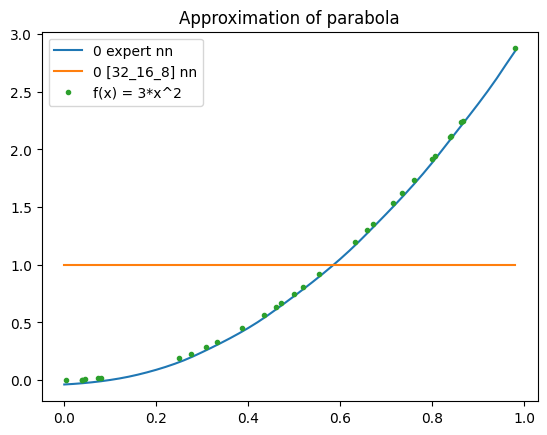

In [103]:
model_from_expert_system = IModel(1, [], 1)
model_from_expert_system.from_dict(result_nn)  # restore model from dict

indices = []
for _ in range(30):
    indices.append(randint(0, len(x_data) - 1))
indices.sort()
x_plot_data = x_data[indices, :]
y_plot_data = y_data[indices, :]

build_plot(
    network=[model_from_expert_system, nn_1_32_16_8_1],  # list of models (or single model)
    interval=(0, 1),  # from where to where to build a plot
    step=0.02,  # step inside bounds
    title="Approximation of parabola",
    labels=["expert nn", "[32_16_8] nn", "f(x) = 3*x^2"],  # labels for plots. Last label for true values
    true_data=[x_plot_data, y_plot_data]
)

### Bulding dataset tables for system of ODE

In [104]:
from degann.equations import SystemODE, system_ode_from_string

In [105]:
str_sode = ("y1*y2 y0(0)=0\n" +
            "-y0*y2 y1(0)=1\n" +
            "-0.5*y0*y1 y2(0)=1")
parsed = system_ode_from_string(str_sode)  # transform to list of strings
sode = SystemODE()
sode.prepare_equations(len(parsed), parsed)  # build functions for each equation
sode.solve((0, 3), 10)  # solve SODE on the interval
table = sode.build_table()
x_ode_data = table[:, :1]
y_ode_data = table[:, 1:]

for feature, value in zip(x_ode_data, y_ode_data):
    print(feature, value)

[0.] [0. 1. 1.]
[0.33333333] [0.32428015 0.94599178 0.97338437]
[0.66666667] [0.60068655 0.7996556  0.90541175]
[1.] [0.80328851 0.59592902 0.82314978]
[1.33333333] [0.9302956  0.3673144  0.75326149]
[1.66666667] [0.991337   0.1321536  0.71315044]
[2.] [ 0.99464172 -0.10352993  0.71072471]
[2.33333333] [ 0.94047783 -0.33840649  0.74599625]
[2.66666667] [ 0.82184152 -0.56690918  0.81176232]
[3.] [ 0.63002234 -0.77317201  0.89233784]


### Bulding dataset tables for functions

In [106]:
from degann.equations import equation_solve, str_eq_to_params

In [107]:
function = "3*x+2*y+4*z"
bounds = {
    "x": "0, 2, 1",  # x from 0 to 2 with step = 1
    "y": "0, 2, 2",  # y from 0 to 2 with step = 2
    "z": "0, 0, 1",  # z = 0
}  # 6 points

variables = str_eq_to_params(bounds)
eq_table = equation_solve(function, variables)

x_eq_data = eq_table[:, :-1]
y_eq_data = eq_table[:, -1:]

for feature, value in zip(x_eq_data, y_eq_data):
    print(feature, value)

[0. 0. 0.] [0.]
[1. 0. 0.] [3.]
[2. 0. 0.] [6.]
[0. 2. 0.] [4.]
[1. 2. 0.] [7.]
[2. 2. 0.] [10.]
